<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 36)
affine: 
[[ -0.44726562   0.           0.         114.27636719]
 [  0.          -0.44726562   0.         313.27636719]
 [  0.           0.           4.5         16.25      ]
 [  0.           0.           0.           1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512  36   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.44726562 0.44726562 4.5        0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_du

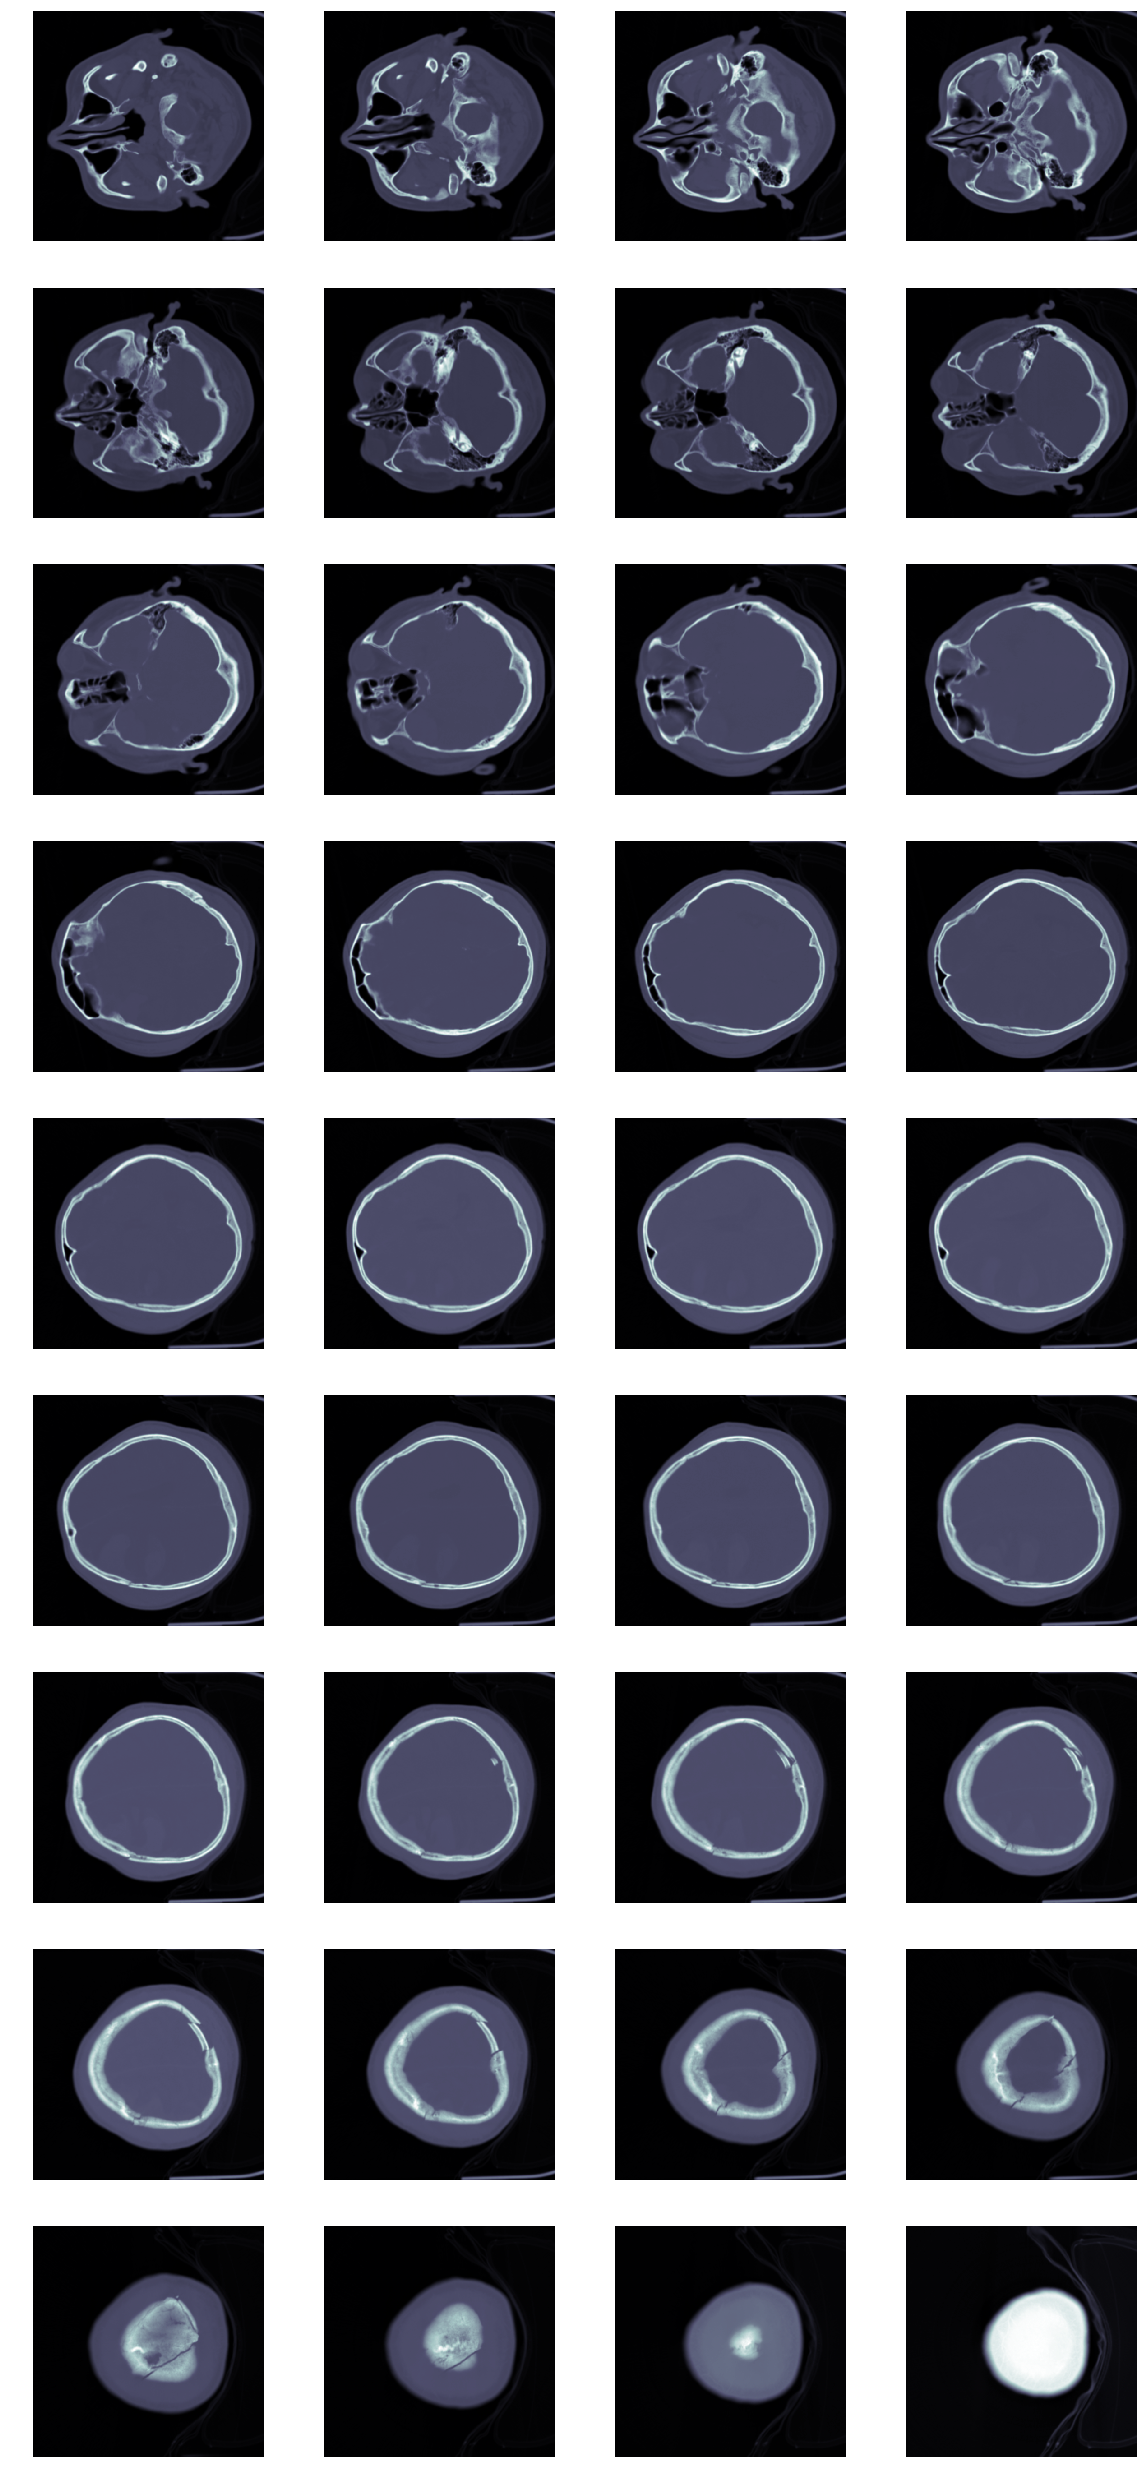

In [132]:

from matplotlib import pylab as plt
%matplotlib inline
import nibabel as nib
from nibabel import nifti1
import numpy as np

def plot_ct_scan(scan, num_column=4, jump=1):
    num_slices = len(scan)
    num_row = (num_slices//jump + num_column - 1) // num_column
    f, plots = plt.subplots(num_row, num_column, figsize=(num_column*5, num_row*5))
    for i in range(0, num_row*num_column):
        plot = plots[i % num_column] if num_row == 1 else plots[i // num_column, i % num_column]        
        plot.axis('off')
        if i < num_slices//jump:
            plot.imshow(scan[i*jump], cmap=plt.cm.bone)
    plt.show()
import gzip

example_filename = '20182074_JIZHEN_GU_2.nii.gz'
img = nib.load(example_filename)
print (img)
affine_matrix = img.affine

slices = np.transpose(img.dataobj, (2, 0, 1))
print(slices.shape)

plot_ct_scan(slices)


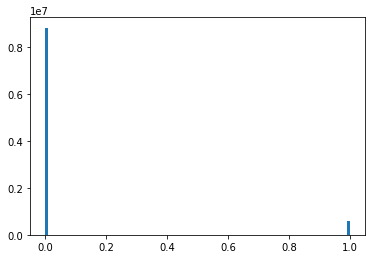

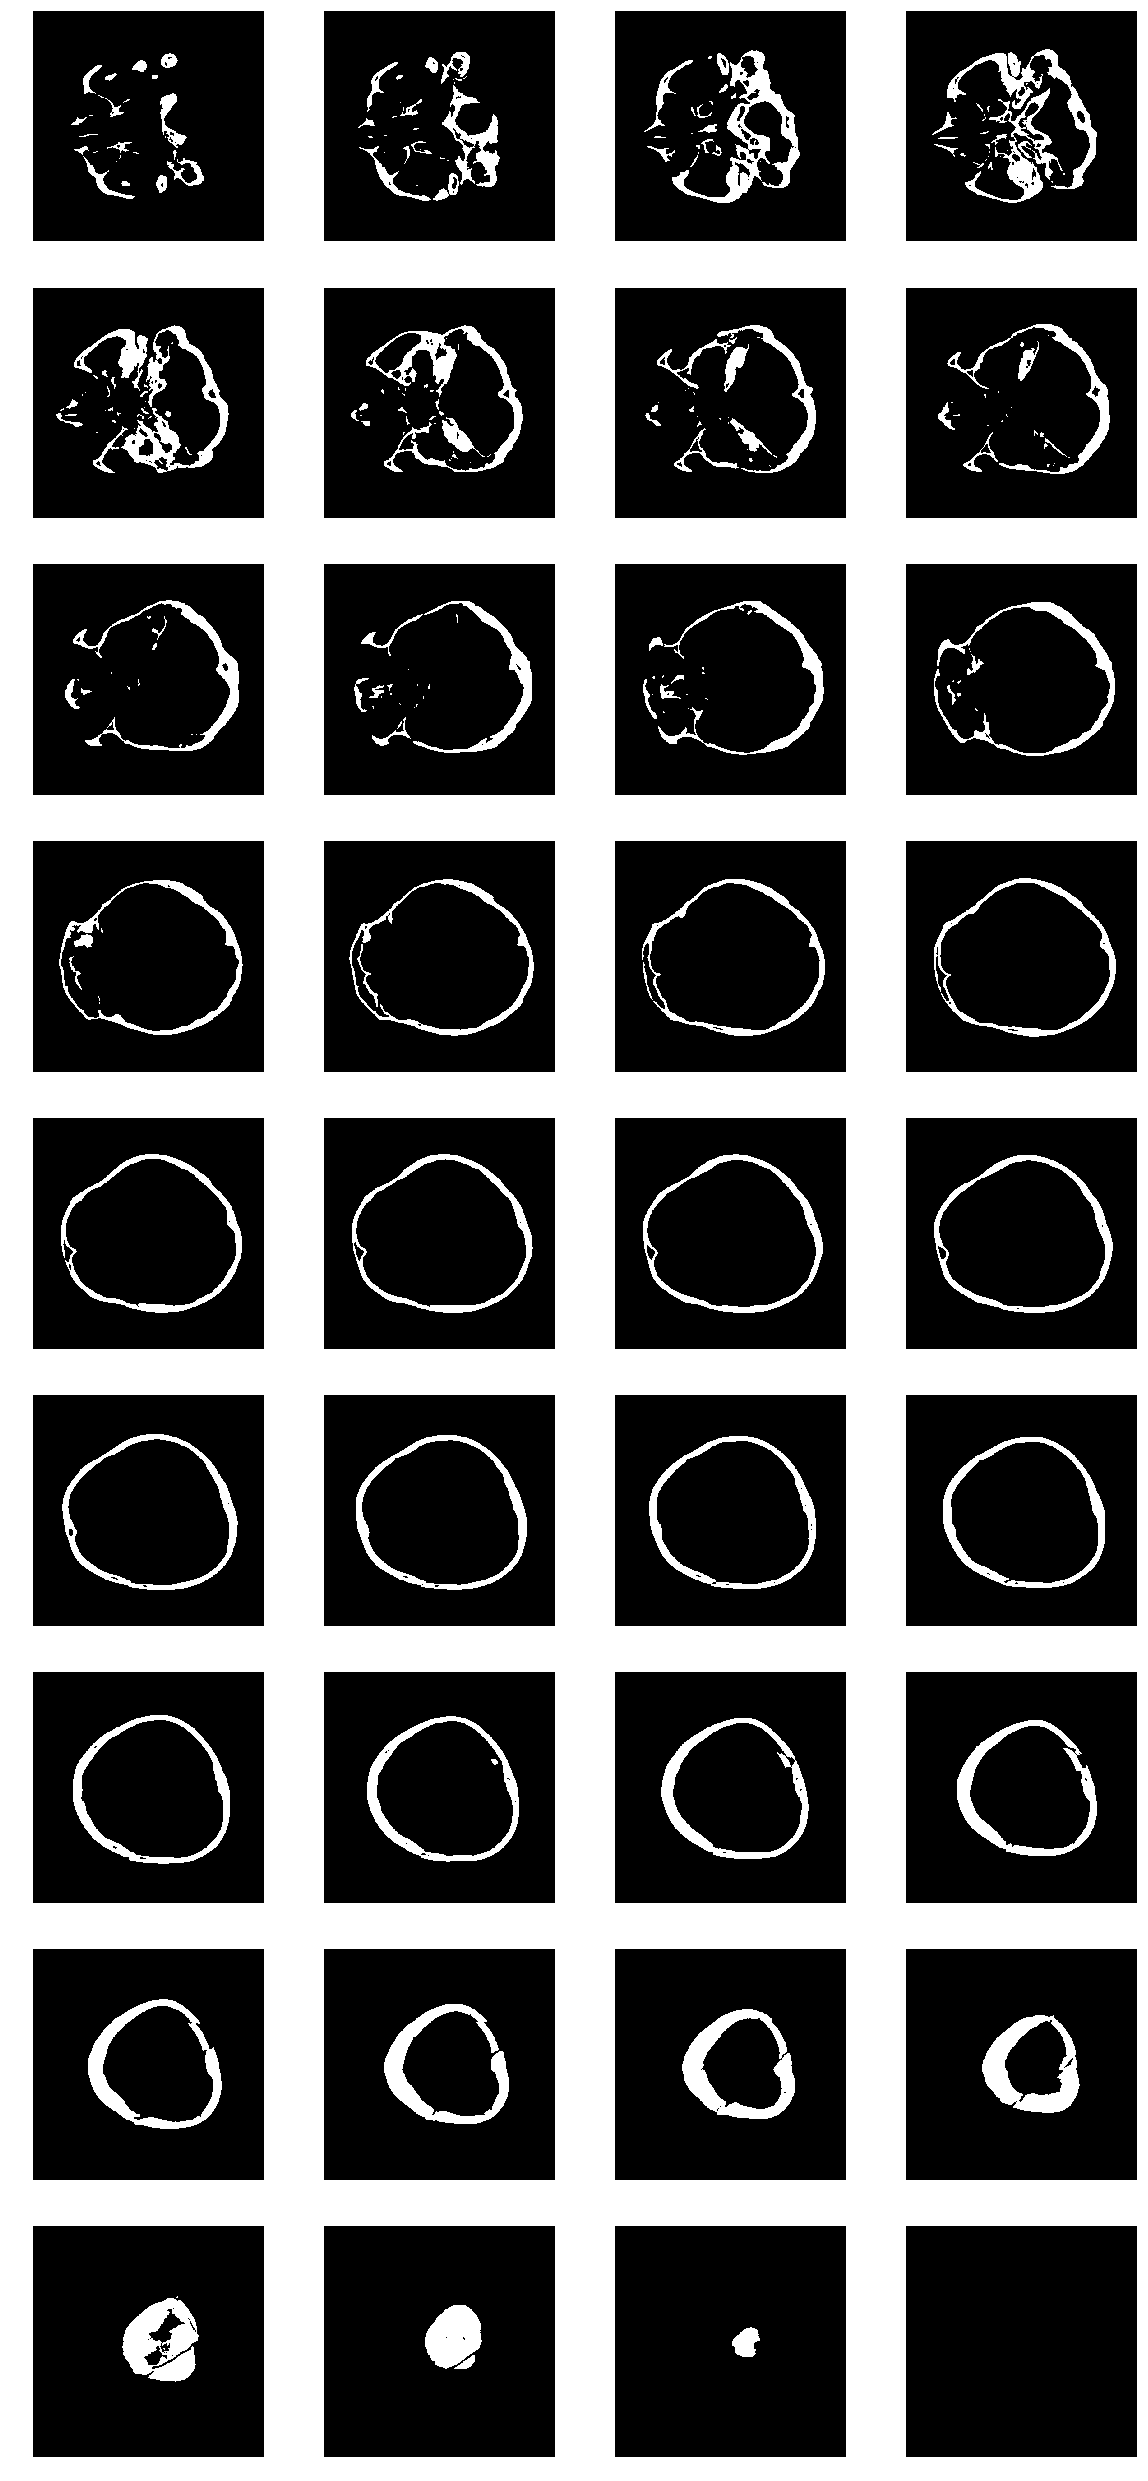

In [133]:
import cv2

def clip(image, hu_min, hu_max):
    image[image < hu_min] = hu_min
    image[image > hu_max] = hu_max
    return (image-hu_min)/(hu_max-hu_min)*255
    
clipped = []
for i,s in enumerate(slices):
    s = clip(np.array(s), 500, 1500)
    clipped.append(s)

# plot_ct_scan(clipped, num_column=4, jump=1)
def threshold(img, theta=0.5):
    img[img<theta] = 0
    img[img>= theta] = 1
    return img

bws = []
for i,s in enumerate(clipped):
    s = threshold(np.array(s))
    bws.append(s)

plt.hist(np.array(bws).flatten(), bins=100)
plt.show()

plot_ct_scan(bws, num_column=4, jump=1)

def prep(slices, clip_lb=0, clib_hb=2500, method='average'):
    clipped = []
    for s in slices[len(slices)//2:len(slices)]:
        s = clip(np.array(s), clip_lb, clib_hb)
        clipped.append(s)
    
    if method == 'average':
        func = np.average
    elif method == 'max':
        func = np.max

    processed = []
    for i in range(len(clipped)):
        img = func(clipped[i:],axis=0)
        #img = img//np.max(img)*255 if np.max(img)>0 else img
        processed.append(img)
    
    return processed


[[ 81 259  18]
 [ 81 258  18]
 [ 81 267  18]
 ...
 [227 301  34]
 [227 308  34]
 [227 291  34]]
[[ 23.14322827 186.86287836 116.41325193]] [[203 282  22]]


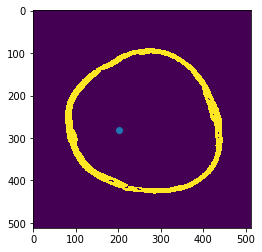

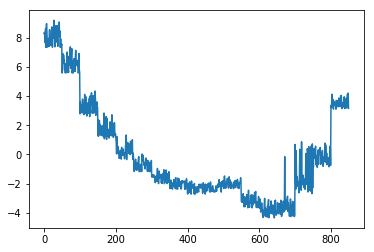

(50.826479394637865, 11.409591731050568)


In [228]:
pts = None
for i in range(len(bws)//2,len(bws)):
    x,y = np.where(bws[i]!=0)
    z = [i for j in range(len(selected))]
    coords = list(zip(x,y,z))
    if len(coords) == 0:
        continue
    indices = [i for i in range(len(coords))]
    selected = np.array(coords)[np.random.choice(indices,np.min((100,len(indices))),replace=False)]
    if pts is None:
        pts = selected
    else:
        pts = np.vstack((pts,selected))
print(pts)

def linear_regression(X,Y):
    print('X',X.shape)
    print('Y',Y.shape)
    W = np.dot(np.dot(Y, X.T), np.linalg.inv(np.dot(X, X.T) + 1e-8 * np.eye(X.shape[0])))
    return W

# print(affine_matrix)
pts_plus = np.hstack((pts, np.ones([len(pts),1])))
# print(pts_plus)
pts_true = np.dot(affine_matrix,pts_plus.T).T[:,:3]
# print(pts_true)
num_pts = len(pts_true)
b = np.zeros((num_pts,1))
W = np.zeros((num_pts,3))
for i in range(num_pts-1):
    b[i] = np.sum(np.square(pts_true[i])-np.square(pts_true[i+1]))
    W[i,:] = 2*(pts_true[i] - pts_true[i+1])
center_true = np.dot(np.linalg.inv(np.dot(W.T,W)),np.dot(W.T,b))
center = np.dot(np.linalg.inv(affine_matrix),np.vstack((center_true,[[1]])))[:3].astype(np.int)
print(center_true.T,center.T)

x,y,z = center[0,0],center[1,0],center[2,0]
plt.imshow(bws[z])
plt.plot(x,y,'o')
plt.show()

def distance(a,b):
    return np.linalg.norm(a-b)

def mean_var(a):
    N = len(a)
    a1=np.array(a)
    s1=a1.sum()
    a2=a1*a1
    s2=a2.sum()
    mean=s1/N
    var=s2/N-mean**2
    return mean, var

distances = []
for i in range(len(pts_true)):
    distances.append(distance(center_true.T[0],pts_true[i]))
m,v = mean_var(distances)
plt.plot(distances-m)
plt.show()
print(mean_var(distances))

In [241]:
lb, hb = np.min(distances), np.max(distances)
print(lb, hb)

theta = np.arange(512)-255
phi = np.arange(512)-255
print(phi)

# for i in range(512):
#     for j in range(512):
#         theta = 
#         phi = 
#         d = distance(np.dot(affine_matrix,np.array([i,j,k,1]).T)[:3].T, center_true.T[0])

#         if d < hb and d > lb:
#             print(i,j,k)
# break

46.48324453332985 60.01116378745212
[-255 -254 -253 -252 -251 -250 -249 -248 -247 -246 -245 -244 -243 -242
 -241 -240 -239 -238 -237 -236 -235 -234 -233 -232 -231 -230 -229 -228
 -227 -226 -225 -224 -223 -222 -221 -220 -219 -218 -217 -216 -215 -214
 -213 -212 -211 -210 -209 -208 -207 -206 -205 -204 -203 -202 -201 -200
 -199 -198 -197 -196 -195 -194 -193 -192 -191 -190 -189 -188 -187 -186
 -185 -184 -183 -182 -181 -180 -179 -178 -177 -176 -175 -174 -173 -172
 -171 -170 -169 -168 -167 -166 -165 -164 -163 -162 -161 -160 -159 -158
 -157 -156 -155 -154 -153 -152 -151 -150 -149 -148 -147 -146 -145 -144
 -143 -142 -141 -140 -139 -138 -137 -136 -135 -134 -133 -132 -131 -130
 -129 -128 -127 -126 -125 -124 -123 -122 -121 -120 -119 -118 -117 -116
 -115 -114 -113 -112 -111 -110 -109 -108 -107 -106 -105 -104 -103 -102
 -101 -100  -99  -98  -97  -96  -95  -94  -93  -92  -91  -90  -89  -88
  -87  -86  -85  -84  -83  -82  -81  -80  -79  -78  -77  -76  -75  -74
  -73  -72  -71  -70  -69  -68  -67  -66 

In [19]:
import numpy as np
func_y = "lambda x: np.sin(x/np.pi)"
func_x = "lambda x: x"
N = 20
dataset = []
dataset.append(eval(func_y)(np.arange(N)/N))
dataset.append(eval(func_x)(np.arange(N)/N))
np.array(list(zip(*dataset))).T

array([[0.        , 0.01591482, 0.03182561, 0.04772834, 0.06361898,
        0.07949351, 0.0953479 , 0.11117814, 0.12698022, 0.14275013,
        0.15848389, 0.1741775 , 0.18982699, 0.2054284 , 0.22097778,
        0.23647118, 0.25190469, 0.26727439, 0.28257638, 0.29780681],
       [0.        , 0.05      , 0.1       , 0.15      , 0.2       ,
        0.25      , 0.3       , 0.35      , 0.4       , 0.45      ,
        0.5       , 0.55      , 0.6       , 0.65      , 0.7       ,
        0.75      , 0.8       , 0.85      , 0.9       , 0.95      ]])

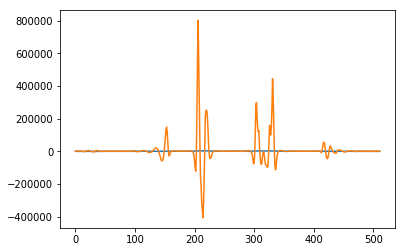

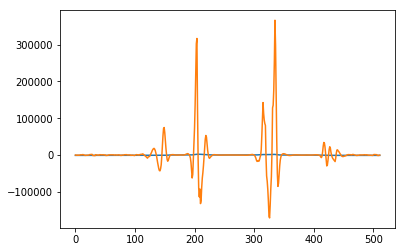

Help on function butter in module scipy.signal.filter_design:

butter(N, Wn, btype='low', analog=False, output='ba', fs=None)
    Butterworth digital and analog filter design.
    
    Design an Nth-order digital or analog Butterworth filter and return
    the filter coefficients.
    
    Parameters
    ----------
    N : int
        The order of the filter.
    Wn : array_like
        A scalar or length-2 sequence giving the critical frequencies.
        For a Butterworth filter, this is the point at which the gain
        drops to 1/sqrt(2) that of the passband (the "-3 dB point").
    
        For digital filters, `Wn` are in the same units as `fs`.  By default,
        `fs` is 2 half-cycles/sample, so these are normalized from 0 to 1,
        where 1 is the Nyquist frequency.  (`Wn` is thus in
        half-cycles / sample.)
    
        For analog filters, `Wn` is an angular frequency (e.g. rad/s).
    btype : {'lowpass', 'highpass', 'bandpass', 'bandstop'}, optional
        The t

In [63]:
import scipy.signal as signal
def find_point(curve):
    x = signal.medfilt(curve,9)
    b, a = signal.butter(5, 0.1, 'highpass')   #配置滤波器 8 表示滤波器的阶数
    filtedData = signal.filtfilt(b, a, x)
    plt.plot(filtedData*x)
    plt.show()
    return 0

trans = np.transpose(slices,(1,0,2))
for i in range(15,17):
    curve = trans[100,i,:]
    plt.plot(curve)
    critic_points = find_point(curve)


#     plt.scatter(critic_points)
#     plt.show()
help(signal.butter)

True

In [ ]:

from matplotlib import pylab as plt
import nibabel as nib
from nibabel import nifti1
import numpy as np
import os
import cv2

def plot_ct_scan(scan, num_column=4, jump=1):
    num_slices = len(scan)
    num_row = (num_slices//jump + num_column - 1) // num_column
    f, plots = plt.subplots(num_row, num_column, figsize=(num_column*5, num_row*5))
    for i in range(0, num_row*num_column):
        plot = plots[i % num_column] if num_row == 1 else plots[i // num_column, i % num_column]        
        plot.axis('off')
        if i < num_slices//jump:
            plot.imshow(scan[i*jump], cmap=plt.cm.bone)
    plt.show()


def clip(image, hu_min, hu_max):
    image[image < hu_min] = hu_min
    image[image > hu_max] = hu_max
    return (image-hu_min)/(hu_max-hu_min)*255


def prep(slices, clip_lb=0, clib_hb=2500, method='average'):
    clipped = []
    for s in slices[len(slices)//2:len(slices)]:
        s = clip(np.array(s), clip_lb, clib_hb)
        clipped.append(s)
    
    if method == 'average':
        func = np.average
    elif method == 'max':
        func = np.max

    processed = []
    for i in range(len(clipped)):
        img = func(clipped[i:],axis=0)
        #img = img//np.max(img)*255 if np.max(img)>0 else img
        processed.append(img)
    
    return processed
    


        
